In [74]:
import matplotlib.pylab as plt
import numpy as np
import os
import pickle
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_io as tfio
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Reshape, PReLU, Conv2D, Concatenate, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Add, Activation, ReLU, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

print("TF version   : ", tf.__version__)
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF version   :  2.10.1
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
SEED = 2748623542
BATCH_SIZE = 32

In [3]:
from dataset import datasetSplit
from dataset import createDataset

train_files, validation_files, test_files = datasetSplit('slices_dicom/sagittal/*.dcm', seed=SEED)

In [4]:
def plotHistory(history):
    x = range(1, 1 + len(history['loss']))

    plt.title('Loss')
    plt.plot(x, history['loss'], label='train')
    plt.plot(x, history['val_loss'], label='validation')
    plt.legend()
    plt.show()

    plt.title('psnr')
    plt.plot(x, history['PSNR'], label='train')
    plt.plot(x, history['val_PSNR'], label='validation')
    plt.legend()
    plt.show()

    plt.title('ssim')
    plt.plot(x, history['SSIM'], label='train')
    plt.plot(x, history['val_SSIM'], label='validation')
    plt.legend()
    plt.show()

In [5]:
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

# Train models for denoising

In [78]:
from models import getModel, ReduceLROnPlateau

def trainModel(name=None, loss=None, augment=None, batch_size=None, train_sample=1000, val_sample=500, epochs=10):
    outPath = 'experiment/' + name + '_' + loss + ('_aug' if augment else '') + '/'
    os.makedirs(outPath, exist_ok=True)

    patience = 10
    patienceLr = 5

    # Create and compile model
    model = getModel(name)
    loss = SSIMLoss if loss == 'ssim' else loss
    optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=0.001, weight_decay=0.004)
    metrics = ['mae', 'mse', SSIM, PSNR]
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Plot model
    tf.keras.utils.plot_model(model, to_file=outPath + 'model.png', expand_nested=True, show_shapes=True)

    # Prepare training and validation datasets
    train_ds = createDataset(train_files, batch_size, seed=SEED, shuffle=True, augment=augment, sample=train_sample)
    val_ds = createDataset(validation_files, batch_size, seed=SEED, sample=val_sample)

    # Train model
    callbacks = [
        ModelCheckpoint(filepath=outPath + "weights-{epoch:02d}-{val_loss:.12f}.tf", save_weights_only=True),
        EarlyStopping(patience=patience, restore_best_weights=True),
        ReduceLROnPlateau(patience=patienceLr)
    ]
    result = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

    # Save training results
    model.save_weights(outPath + 'bestWeigths.tf')
    with open(outPath + 'trainresult.bin', 'wb') as f:
        pickle.dump(result.history, f, pickle.HIGHEST_PROTOCOL)

    # Plot loss and metrics evolution during training
    plotHistory(result.history)


Epoch 1/50
1288/1288 [==============================] - 880s 281ms/step - loss: 0.0080 - mae: 0.0080 - mse: 4.4226e-04 - SSIM: 0.9858 - PSNR: 40.4726 - val_loss: 0.0053 - val_mae: 0.0053 - val_mse: 6.6730e-05 - val_SSIM: 0.9931 - val_PSNR: 42.0759 - lr: 0.0010 - wd: 0.0040
Epoch 2/50
1288/1288 [==============================] - 266s 207ms/step - loss: 0.0060 - mae: 0.0060 - mse: 9.4228e-05 - SSIM: 0.9940 - PSNR: 42.4961 - val_loss: 0.0052 - val_mae: 0.0052 - val_mse: 5.3980e-05 - val_SSIM: 0.9879 - val_PSNR: 42.8259 - lr: 0.0010 - wd: 0.0040
Epoch 3/50
1288/1288 [==============================] - 263s 204ms/step - loss: 0.0051 - mae: 0.0051 - mse: 7.4236e-05 - SSIM: 0.9945 - PSNR: 43.8439 - val_loss: 0.0057 - val_mae: 0.0057 - val_mse: 7.0043e-05 - val_SSIM: 0.9924 - val_PSNR: 42.0623 - lr: 0.0010 - wd: 0.0040
Epoch 4/50
1288/1288 [==============================] - 263s 204ms/step - loss: 0.0042 - mae: 0.0042 - mse: 4.8527e-05 - SSIM: 0.9960 - PSNR: 45.3575 - val_loss: 0.0044 - val_mae

1288/1288 [==============================] - 261s 203ms/step - loss: 0.0011 - mae: 0.0011 - mse: 3.4357e-06 - SSIM: 0.9998 - PSNR: 56.9229 - val_loss: 4.3234e-04 - val_mae: 4.3234e-04 - val_mse: 5.0001e-07 - val_SSIM: 0.9999 - val_PSNR: 63.3713 - lr: 1.0000e-05 - wd: 4.0000e-05
Epoch 31/50
1288/1288 [==============================] - 261s 203ms/step - loss: 0.0011 - mae: 0.0011 - mse: 3.4828e-06 - SSIM: 0.9998 - PSNR: 56.8687 - val_loss: 4.3251e-04 - val_mae: 4.3251e-04 - val_mse: 4.9916e-07 - val_SSIM: 0.9999 - val_PSNR: 63.3743 - lr: 1.0000e-05 - wd: 4.0000e-05
Epoch 32/50
1288/1288 [==============================] - 265s 206ms/step - loss: 0.0011 - mae: 0.0011 - mse: 3.4178e-06 - SSIM: 0.9998 - PSNR: 56.8372 - val_loss: 4.7380e-04 - val_mae: 4.7380e-04 - val_mse: 5.6692e-07 - val_SSIM: 0.9998 - val_PSNR: 62.7715 - lr: 1.0000e-05 - wd: 4.0000e-05
Epoch 33/50
1288/1288 [==============================] - 266s 206ms/step - loss: 0.0011 - mae: 0.0011 - mse: 3.3767e-06 - SSIM: 0.9998 - PS

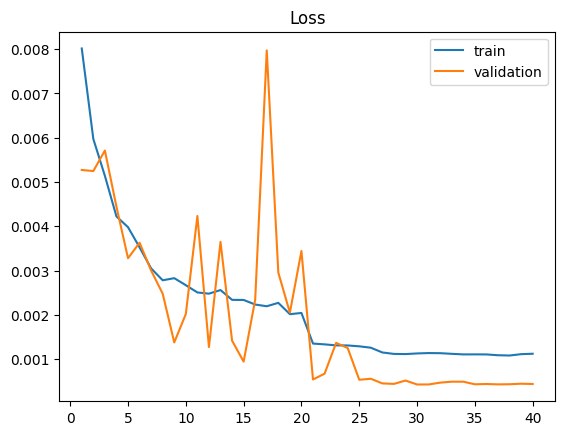

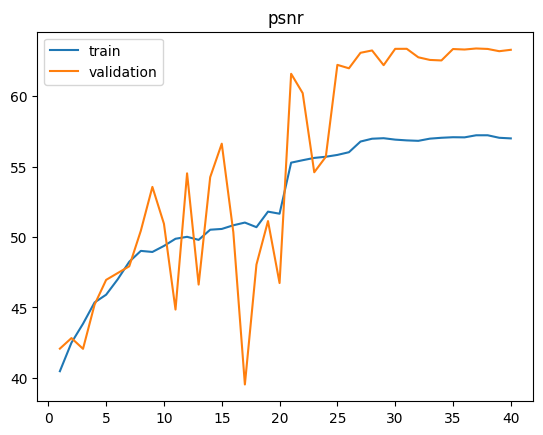

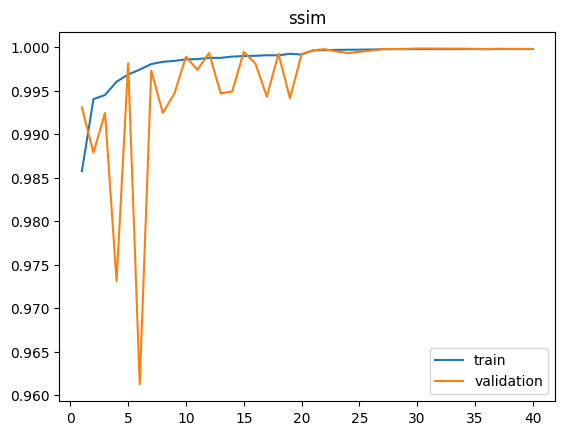

In [79]:
trainModel(name='resunet', loss='mae', augment=False, batch_size=32, train_sample=None, val_sample=None, epochs=50)

Epoch 1/50
1288/1288 [==============================] - 948s 284ms/step - loss: 0.0130 - mae: 0.0130 - mse: 0.0013 - SSIM: 0.9463 - PSNR: 33.5477 - val_loss: 0.0069 - val_mae: 0.0069 - val_mse: 1.4161e-04 - val_SSIM: 0.9815 - val_PSNR: 39.0014 - lr: 0.0010 - wd: 0.0040
Epoch 2/50
1288/1288 [==============================] - 263s 204ms/step - loss: 0.0095 - mae: 0.0095 - mse: 5.0451e-04 - SSIM: 0.9581 - PSNR: 35.5124 - val_loss: 0.0044 - val_mae: 0.0044 - val_mse: 6.6578e-05 - val_SSIM: 0.9859 - val_PSNR: 42.7092 - lr: 0.0010 - wd: 0.0040
Epoch 3/50
1288/1288 [==============================] - 262s 204ms/step - loss: 0.0081 - mae: 0.0081 - mse: 3.7945e-04 - SSIM: 0.9666 - PSNR: 37.0070 - val_loss: 0.0046 - val_mae: 0.0046 - val_mse: 4.9498e-05 - val_SSIM: 0.9953 - val_PSNR: 43.3917 - lr: 0.0010 - wd: 0.0040
Epoch 4/50
1288/1288 [==============================] - 262s 203ms/step - loss: 0.0071 - mae: 0.0071 - mse: 2.8694e-04 - SSIM: 0.9735 - PSNR: 38.3271 - val_loss: 0.0039 - val_mae: 0.

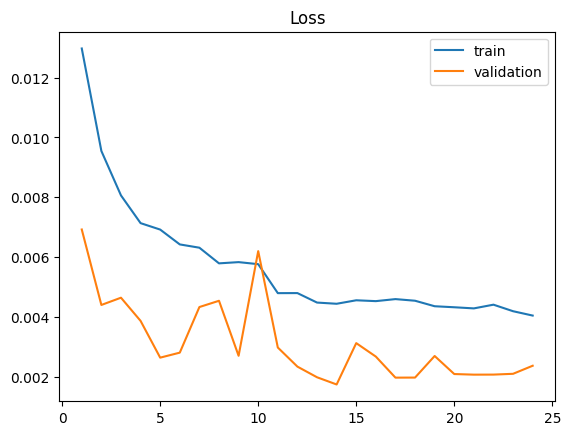

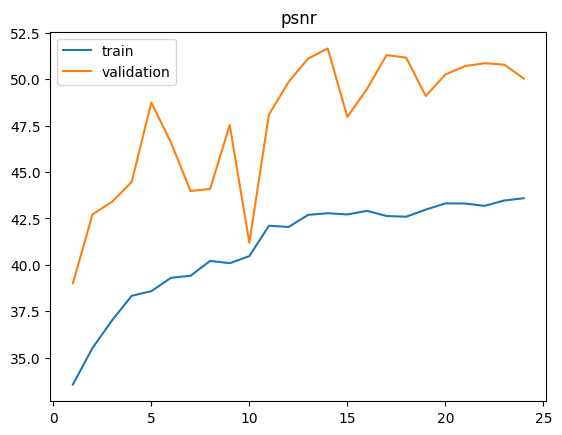

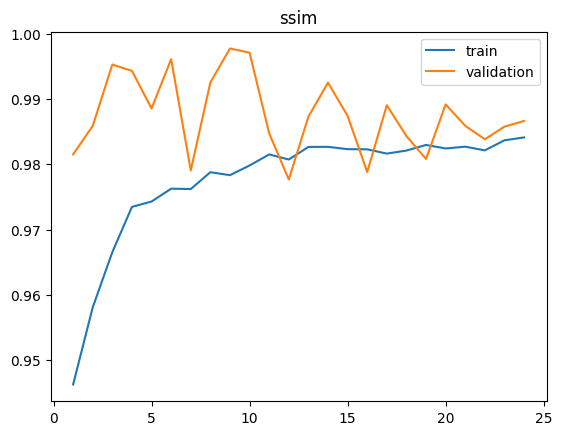

In [80]:
trainModel(name='resunet', loss='mae', augment=True, batch_size=32, train_sample=None, val_sample=None, epochs=50)

Epoch 1/50
2576/2576 [==============================] - 2427s 655ms/step - loss: 0.0031 - mae: 0.0031 - mse: 7.8648e-04 - SSIM: 0.9910 - PSNR: 53.3058 - val_loss: 0.0013 - val_mae: 0.0013 - val_mse: 2.9307e-06 - val_SSIM: 0.9992 - val_PSNR: 56.0500 - lr: 0.0010 - wd: 0.0040
Epoch 2/50
2576/2576 [==============================] - 1547s 601ms/step - loss: 0.0011 - mae: 0.0011 - mse: 2.7930e-06 - SSIM: 0.9993 - PSNR: 57.5497 - val_loss: 5.9667e-04 - val_mae: 5.9667e-04 - val_mse: 7.9138e-07 - val_SSIM: 1.0000 - val_PSNR: 61.5214 - lr: 0.0010 - wd: 0.0040
Epoch 3/50
2576/2576 [==============================] - 1545s 600ms/step - loss: 9.4734e-04 - mae: 9.4734e-04 - mse: 1.8617e-06 - SSIM: 0.9994 - PSNR: 59.0278 - val_loss: 0.0014 - val_mae: 0.0014 - val_mse: 3.7576e-06 - val_SSIM: 0.9996 - val_PSNR: 54.6272 - lr: 0.0010 - wd: 0.0040
Epoch 4/50
2576/2576 [==============================] - 1544s 599ms/step - loss: 8.2789e-04 - mae: 8.2789e-04 - mse: 1.4013e-06 - SSIM: 0.9995 - PSNR: 60.2941 

Epoch 29/50
2576/2576 [==============================] - 1562s 606ms/step - loss: 2.7025e-06 - mae: 2.7025e-06 - mse: 5.7142e-08 - SSIM: 1.0000 - PSNR: 96.4028 - val_loss: 2.1500e-06 - val_mae: 2.1500e-06 - val_mse: 9.9661e-09 - val_SSIM: 1.0000 - val_PSNR: 97.1377 - lr: 1.0000e-06 - wd: 4.0000e-06
Epoch 30/50
2576/2576 [==============================] - 1560s 606ms/step - loss: 2.6719e-06 - mae: 2.6719e-06 - mse: 5.7140e-08 - SSIM: 1.0000 - PSNR: 96.4296 - val_loss: 2.5339e-06 - val_mae: 2.5339e-06 - val_mse: 9.9669e-09 - val_SSIM: 1.0000 - val_PSNR: 97.1105 - lr: 1.0000e-06 - wd: 4.0000e-06
Epoch 31/50
2576/2576 [==============================] - 1596s 620ms/step - loss: 2.6498e-06 - mae: 2.6498e-06 - mse: 5.7137e-08 - SSIM: 1.0000 - PSNR: 96.4623 - val_loss: 2.2597e-06 - val_mae: 2.2597e-06 - val_mse: 9.9632e-09 - val_SSIM: 1.0000 - val_PSNR: 97.1904 - lr: 1.0000e-06 - wd: 4.0000e-06
Epoch 32/50
2576/2576 [==============================] - 1615s 627ms/step - loss: 2.6828e-06 - mae: 

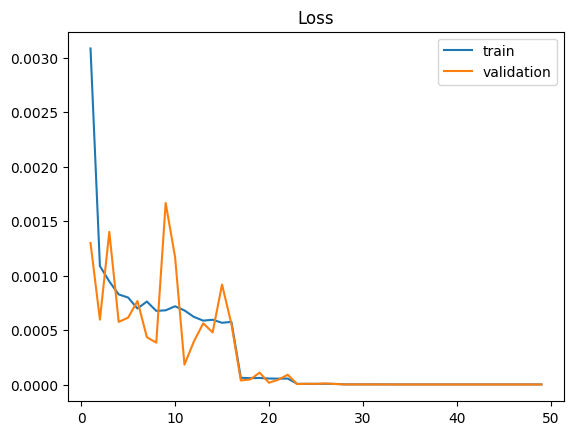

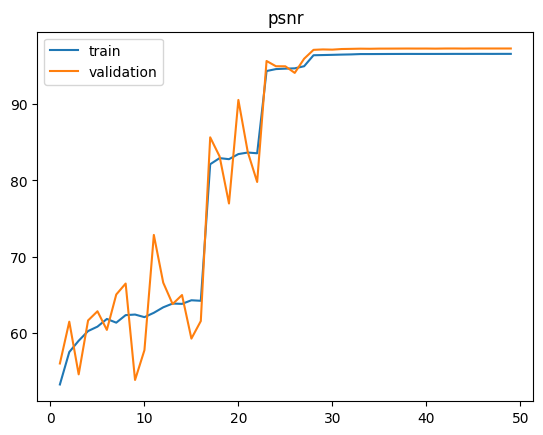

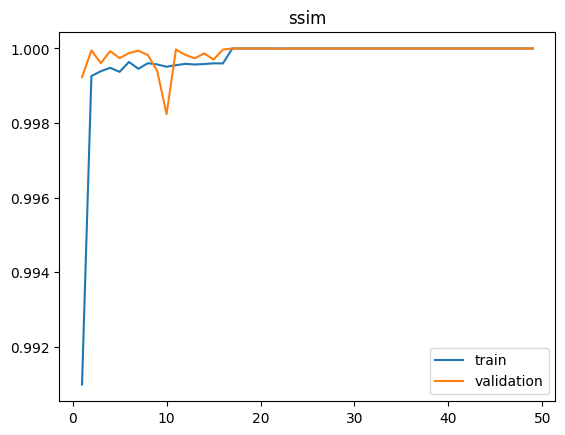

In [81]:
trainModel(name='rdn', loss='mae', augment=False, batch_size=16, train_sample=None, val_sample=None, epochs=50)

Epoch 1/50
2576/2576 [==============================] - 2565s 710ms/step - loss: 0.0112 - mae: 0.0112 - mse: 0.0028 - SSIM: 0.9474 - PSNR: 35.4291 - val_loss: 0.0027 - val_mae: 0.0027 - val_mse: 1.7048e-05 - val_SSIM: 0.9949 - val_PSNR: 48.1294 - lr: 0.0010 - wd: 0.0040
Epoch 2/50
2576/2576 [==============================] - 1576s 612ms/step - loss: 0.0076 - mae: 0.0076 - mse: 8.9457e-04 - SSIM: 0.9649 - PSNR: 37.8215 - val_loss: 0.0025 - val_mae: 0.0025 - val_mse: 1.8640e-05 - val_SSIM: 0.9954 - val_PSNR: 47.5699 - lr: 0.0010 - wd: 0.0040
Epoch 3/50
2576/2576 [==============================] - 1577s 612ms/step - loss: 0.0071 - mae: 0.0071 - mse: 8.5232e-04 - SSIM: 0.9652 - PSNR: 38.3929 - val_loss: 0.0050 - val_mae: 0.0050 - val_mse: 4.6952e-05 - val_SSIM: 0.9912 - val_PSNR: 43.4942 - lr: 0.0010 - wd: 0.0040
Epoch 4/50
2576/2576 [==============================] - 1564s 607ms/step - loss: 0.0067 - mae: 0.0067 - mse: 7.7880e-04 - SSIM: 0.9678 - PSNR: 39.1640 - val_loss: 0.0039 - val_mae

Epoch 30/50
2576/2576 [==============================] - 1586s 616ms/step - loss: 0.0029 - mae: 0.0029 - mse: 1.1382e-04 - SSIM: 0.9870 - PSNR: 51.7977 - val_loss: 5.2817e-05 - val_mae: 5.2817e-05 - val_mse: 2.9013e-07 - val_SSIM: 1.0000 - val_PSNR: 72.3635 - lr: 1.0000e-06 - wd: 4.0000e-06
Epoch 31/50
2576/2576 [==============================] - 1577s 612ms/step - loss: 0.0029 - mae: 0.0029 - mse: 1.1396e-04 - SSIM: 0.9869 - PSNR: 52.0918 - val_loss: 5.1693e-05 - val_mae: 5.1693e-05 - val_mse: 2.8725e-07 - val_SSIM: 1.0000 - val_PSNR: 72.4308 - lr: 1.0000e-07 - wd: 4.0000e-07
Epoch 32/50
2576/2576 [==============================] - 1576s 612ms/step - loss: 0.0029 - mae: 0.0029 - mse: 1.1928e-04 - SSIM: 0.9866 - PSNR: 52.2617 - val_loss: 5.2001e-05 - val_mae: 5.2001e-05 - val_mse: 2.8757e-07 - val_SSIM: 1.0000 - val_PSNR: 72.4083 - lr: 1.0000e-07 - wd: 4.0000e-07
Epoch 33/50
2576/2576 [==============================] - 1578s 612ms/step - loss: 0.0028 - mae: 0.0028 - mse: 1.1390e-04 - S

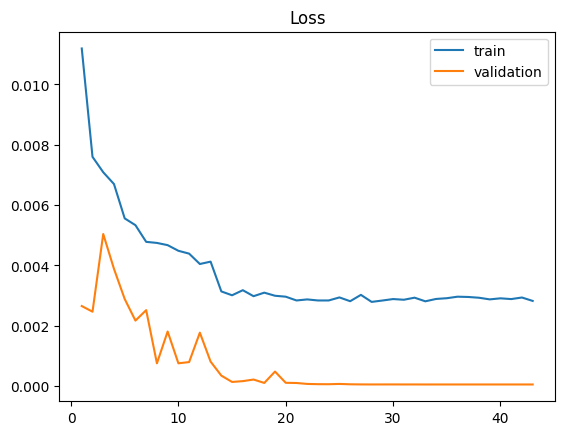

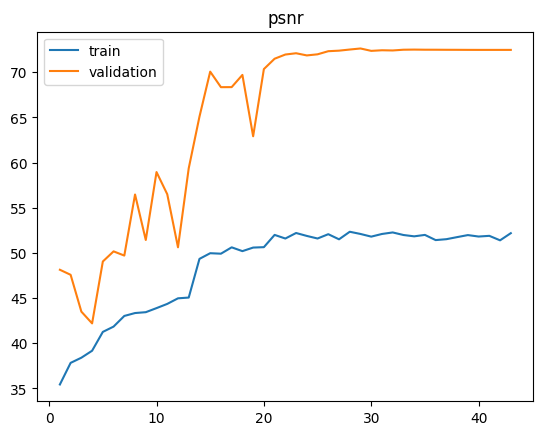

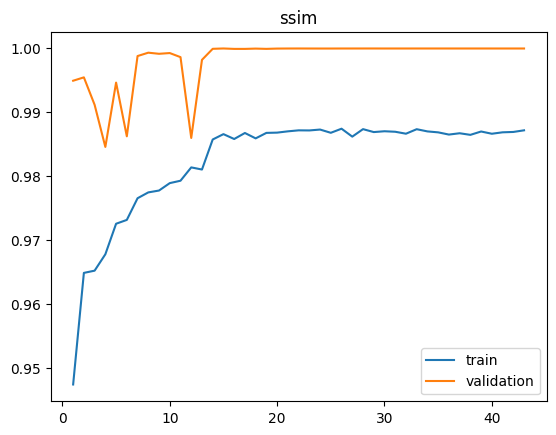

In [82]:
trainModel(name='rdn', loss='mae', augment=True, batch_size=16, train_sample=None, val_sample=None, epochs=50)

# Add upscaling layer to the trained models

In [83]:
from models import getModel, ReduceLROnPlateau

def upscale(x, upscale_factor=2, filters=64, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    x = Conv2D(filters, 5, **conv_args)(x)
    x = Conv2D(filters, 3, **conv_args)(x)
    x = Conv2D(filters / 2, 3, **conv_args)(x)
    x = Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return outputs

def trainSRModel(name=None, weights=None, loss=None, augment=None, batch_size=None, train_sample=1000, val_sample=500, epochs=10):
    outPath = 'experiment/' + name + 'SR' + ('_transfer' if weights != None else '') + '_' + loss + ('_aug' if augment else '') + '/'
    os.makedirs(outPath, exist_ok=True)

    patience = 10
    patienceLr = 5

    # Create and compile model
    model = getModel(name)
    if weights != None:
        model.load_weights(weights).expect_partial()
    model.trainable=False
    inputs = model.inputs
    outputs = upscale(model.layers[-1].input)
    model = Model(inputs=inputs, outputs=outputs)

    loss = SSIMLoss if loss == 'ssim' else loss
    optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=0.001, weight_decay=0.004)
    metrics = ['mae', 'mse', SSIM, PSNR]
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Plot model
    tf.keras.utils.plot_model(model, to_file=outPath + 'model.png', expand_nested=True, show_shapes=True)

    # Prepare training and validation datasets
    train_ds = createDataset(train_files, batch_size, output_size=(256, 256), seed=SEED, shuffle=True, augment=augment, sample=train_sample)
    val_ds = createDataset(validation_files, batch_size, output_size=(256, 256), seed=SEED, sample=val_sample)

    # Train model
    callbacks = [
        ModelCheckpoint(filepath=outPath + "weights-{epoch:02d}-{val_loss:.7f}", save_weights_only=True),
        EarlyStopping(patience=patience, restore_best_weights=True),
        ReduceLROnPlateau(patience=patienceLr)
    ]
    result = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

    # Save training results
    model.save_weights(outPath + 'bestWeigths')
    with open(outPath + 'trainresult.bin', 'wb') as f:
        pickle.dump(result.history, f, pickle.HIGHEST_PROTOCOL)

    # Plot loss and metrics evolution during training
    plotHistory(result.history)

    # TODO: fine tuning

Epoch 1/50
1288/1288 [==============================] - 1161s 261ms/step - loss: 0.0159 - mae: 0.0159 - mse: 0.0020 - SSIM: 0.9063 - PSNR: 33.6447 - val_loss: 0.0090 - val_mae: 0.0090 - val_mse: 2.5823e-04 - val_SSIM: 0.9615 - val_PSNR: 36.3943 - lr: 0.0010 - wd: 0.0040
Epoch 2/50
1288/1288 [==============================] - 192s 149ms/step - loss: 0.0086 - mae: 0.0086 - mse: 2.5723e-04 - SSIM: 0.9635 - PSNR: 36.4495 - val_loss: 0.0078 - val_mae: 0.0078 - val_mse: 2.1290e-04 - val_SSIM: 0.9665 - val_PSNR: 37.3125 - lr: 0.0010 - wd: 0.0040
Epoch 3/50
1288/1288 [==============================] - 191s 148ms/step - loss: 0.0083 - mae: 0.0083 - mse: 2.4250e-04 - SSIM: 0.9654 - PSNR: 36.7100 - val_loss: 0.0077 - val_mae: 0.0077 - val_mse: 2.0931e-04 - val_SSIM: 0.9674 - val_PSNR: 37.3861 - lr: 0.0010 - wd: 0.0040
Epoch 4/50
1288/1288 [==============================] - 191s 148ms/step - loss: 0.0081 - mae: 0.0081 - mse: 2.3431e-04 - SSIM: 0.9665 - PSNR: 36.8638 - val_loss: 0.0074 - val_mae: 0

1288/1288 [==============================] - 192s 149ms/step - loss: 0.0075 - mae: 0.0075 - mse: 2.0913e-04 - SSIM: 0.9700 - PSNR: 37.3916 - val_loss: 0.0070 - val_mae: 0.0070 - val_mse: 1.8439e-04 - val_SSIM: 0.9712 - val_PSNR: 37.9717 - lr: 1.0000e-07 - wd: 4.0000e-07
Epoch 31/50
1288/1288 [==============================] - 191s 148ms/step - loss: 0.0075 - mae: 0.0075 - mse: 2.0913e-04 - SSIM: 0.9700 - PSNR: 37.3916 - val_loss: 0.0070 - val_mae: 0.0070 - val_mse: 1.8439e-04 - val_SSIM: 0.9712 - val_PSNR: 37.9715 - lr: 1.0000e-07 - wd: 4.0000e-07
Epoch 32/50
1288/1288 [==============================] - 191s 148ms/step - loss: 0.0075 - mae: 0.0075 - mse: 2.0913e-04 - SSIM: 0.9700 - PSNR: 37.3916 - val_loss: 0.0070 - val_mae: 0.0070 - val_mse: 1.8439e-04 - val_SSIM: 0.9712 - val_PSNR: 37.9716 - lr: 1.0000e-07 - wd: 4.0000e-07
Epoch 33/50
1288/1288 [==============================] - 191s 148ms/step - loss: 0.0075 - mae: 0.0075 - mse: 2.0913e-04 - SSIM: 0.9700 - PSNR: 37.3916 - val_loss: 

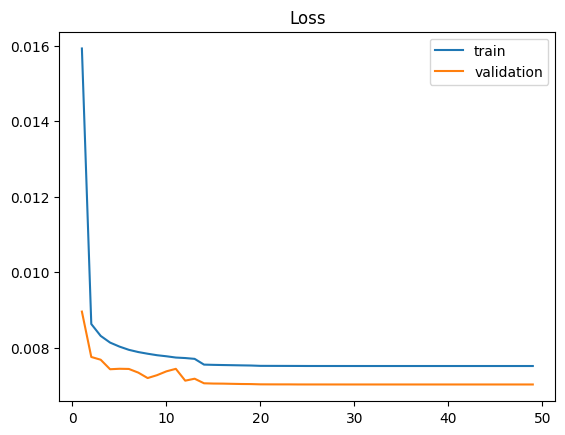

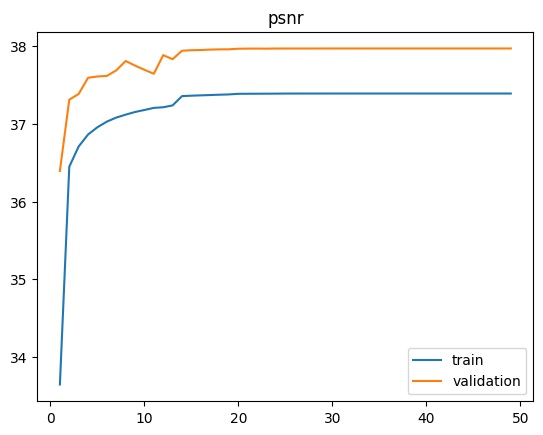

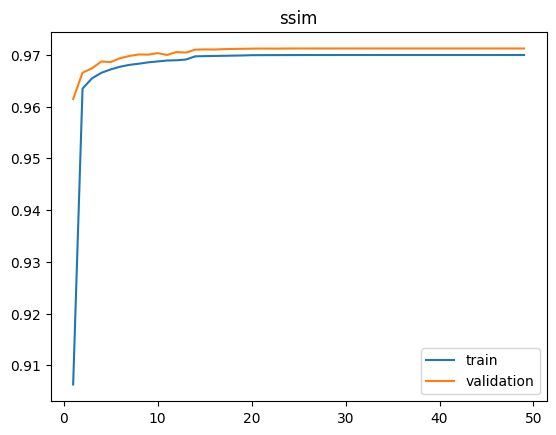

In [84]:
trainSRModel(name='resunet', weights='experiment/resunet_mae/bestWeigths.tf', loss='mae', augment=False, batch_size=32, train_sample=None, val_sample=None, epochs=50)

Epoch 1/50
1288/1288 [==============================] - 1140s 264ms/step - loss: 0.0283 - mae: 0.0283 - mse: 0.0056 - SSIM: 0.7917 - PSNR: 28.3846 - val_loss: 0.0099 - val_mae: 0.0099 - val_mse: 3.2331e-04 - val_SSIM: 0.9514 - val_PSNR: 35.4303 - lr: 0.0010 - wd: 0.0040
Epoch 2/50
1288/1288 [==============================] - 193s 150ms/step - loss: 0.0139 - mae: 0.0139 - mse: 7.1361e-04 - SSIM: 0.9073 - PSNR: 32.4102 - val_loss: 0.0093 - val_mae: 0.0093 - val_mse: 2.9083e-04 - val_SSIM: 0.9544 - val_PSNR: 35.8818 - lr: 0.0010 - wd: 0.0040
Epoch 3/50
1288/1288 [==============================] - 193s 150ms/step - loss: 0.0131 - mae: 0.0131 - mse: 6.4047e-04 - SSIM: 0.9151 - PSNR: 32.8837 - val_loss: 0.0097 - val_mae: 0.0097 - val_mse: 3.1064e-04 - val_SSIM: 0.9543 - val_PSNR: 35.5459 - lr: 0.0010 - wd: 0.0040
Epoch 4/50
1288/1288 [==============================] - 192s 149ms/step - loss: 0.0128 - mae: 0.0128 - mse: 6.1539e-04 - SSIM: 0.9183 - PSNR: 33.0411 - val_loss: 0.0114 - val_mae: 0

1288/1288 [==============================] - 188s 146ms/step - loss: 0.0107 - mae: 0.0107 - mse: 4.5665e-04 - SSIM: 0.9386 - PSNR: 34.4038 - val_loss: 0.0082 - val_mae: 0.0082 - val_mse: 2.3451e-04 - val_SSIM: 0.9626 - val_PSNR: 36.7947 - lr: 1.0000e-07 - wd: 4.0000e-07
Epoch 31/50
1288/1288 [==============================] - 188s 146ms/step - loss: 0.0108 - mae: 0.0108 - mse: 4.5648e-04 - SSIM: 0.9375 - PSNR: 34.3700 - val_loss: 0.0082 - val_mae: 0.0082 - val_mse: 2.3455e-04 - val_SSIM: 0.9626 - val_PSNR: 36.7938 - lr: 1.0000e-07 - wd: 4.0000e-07
Epoch 32/50
1288/1288 [==============================] - 188s 146ms/step - loss: 0.0108 - mae: 0.0108 - mse: 4.5060e-04 - SSIM: 0.9369 - PSNR: 34.4030 - val_loss: 0.0082 - val_mae: 0.0082 - val_mse: 2.3437e-04 - val_SSIM: 0.9626 - val_PSNR: 36.7992 - lr: 1.0000e-07 - wd: 4.0000e-07
Epoch 33/50
1288/1288 [==============================] - 188s 146ms/step - loss: 0.0107 - mae: 0.0107 - mse: 4.4903e-04 - SSIM: 0.9382 - PSNR: 34.4260 - val_loss: 

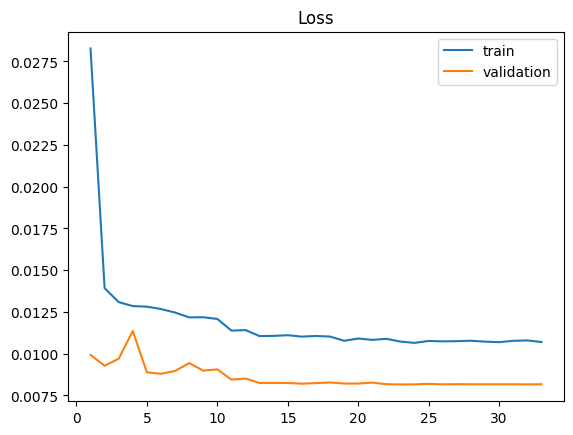

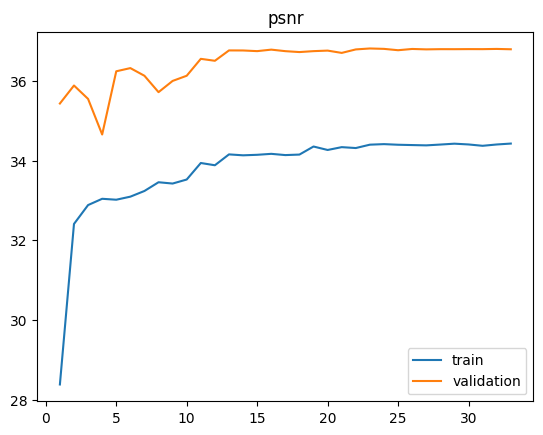

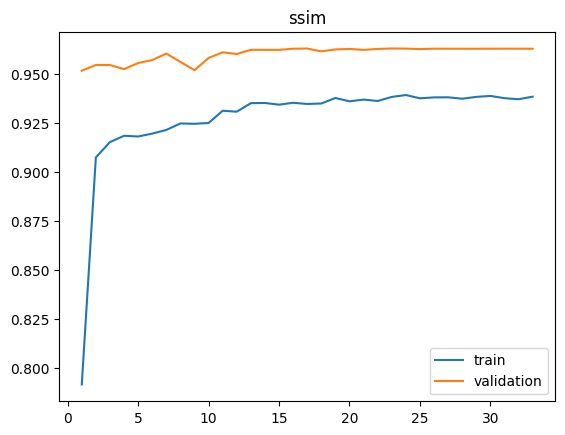

In [85]:
trainSRModel(name='resunet', weights='experiment/resunet_mae_aug/bestWeigths.tf', loss='mae', augment=True, batch_size=32, train_sample=None, val_sample=None, epochs=50)

Epoch 1/50
1288/1288 [==============================] - 2118s 777ms/step - loss: 0.0254 - mae: 0.0254 - mse: 0.0056 - SSIM: 0.7748 - PSNR: 28.3882 - val_loss: 0.0076 - val_mae: 0.0076 - val_mse: 2.0943e-04 - val_SSIM: 0.9685 - val_PSNR: 37.4334 - lr: 0.0010 - wd: 0.0040
Epoch 2/50
1288/1288 [==============================] - 557s 432ms/step - loss: 0.0081 - mae: 0.0081 - mse: 2.3397e-04 - SSIM: 0.9676 - PSNR: 36.9146 - val_loss: 0.0073 - val_mae: 0.0073 - val_mse: 1.9745e-04 - val_SSIM: 0.9696 - val_PSNR: 37.6964 - lr: 0.0010 - wd: 0.0040
Epoch 3/50
1288/1288 [==============================] - 557s 432ms/step - loss: 0.0079 - mae: 0.0079 - mse: 2.2748e-04 - SSIM: 0.9682 - PSNR: 37.0384 - val_loss: 0.0077 - val_mae: 0.0077 - val_mse: 2.0941e-04 - val_SSIM: 0.9699 - val_PSNR: 37.4182 - lr: 0.0010 - wd: 0.0040
Epoch 4/50
1288/1288 [==============================] - 557s 432ms/step - loss: 0.0078 - mae: 0.0078 - mse: 2.2434e-04 - SSIM: 0.9686 - PSNR: 37.1001 - val_loss: 0.0072 - val_mae: 0

1288/1288 [==============================] - 557s 432ms/step - loss: 0.0075 - mae: 0.0075 - mse: 2.1113e-04 - SSIM: 0.9700 - PSNR: 37.3679 - val_loss: 0.0070 - val_mae: 0.0070 - val_mse: 1.8531e-04 - val_SSIM: 0.9714 - val_PSNR: 37.9727 - lr: 1.0000e-07 - wd: 4.0000e-07
Epoch 31/50
1288/1288 [==============================] - 557s 432ms/step - loss: 0.0075 - mae: 0.0075 - mse: 2.1112e-04 - SSIM: 0.9700 - PSNR: 37.3679 - val_loss: 0.0070 - val_mae: 0.0070 - val_mse: 1.8531e-04 - val_SSIM: 0.9714 - val_PSNR: 37.9726 - lr: 1.0000e-08 - wd: 4.0000e-08
Epoch 32/50
1288/1288 [==============================] - 557s 433ms/step - loss: 0.0075 - mae: 0.0075 - mse: 2.1112e-04 - SSIM: 0.9700 - PSNR: 37.3680 - val_loss: 0.0070 - val_mae: 0.0070 - val_mse: 1.8531e-04 - val_SSIM: 0.9714 - val_PSNR: 37.9726 - lr: 1.0000e-08 - wd: 4.0000e-08
Epoch 33/50
1288/1288 [==============================] - 556s 432ms/step - loss: 0.0075 - mae: 0.0075 - mse: 2.1112e-04 - SSIM: 0.9700 - PSNR: 37.3680 - val_loss: 

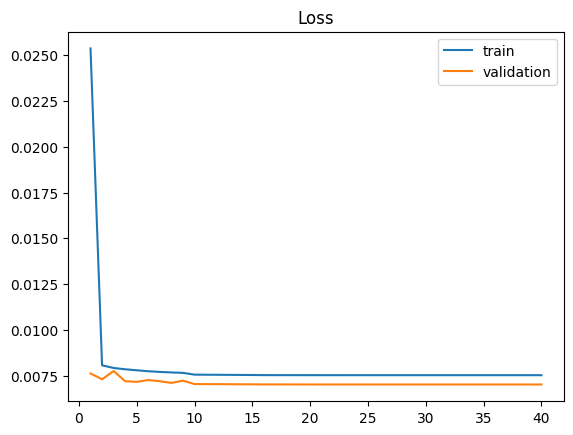

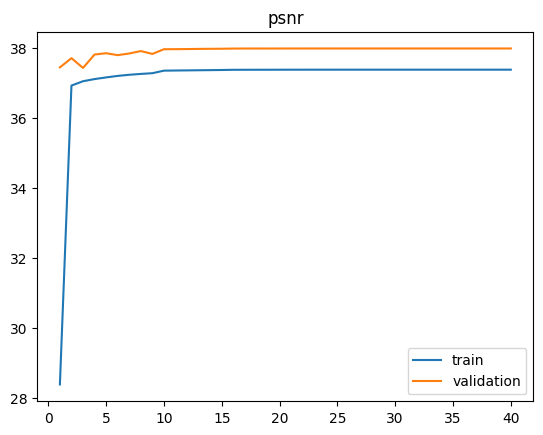

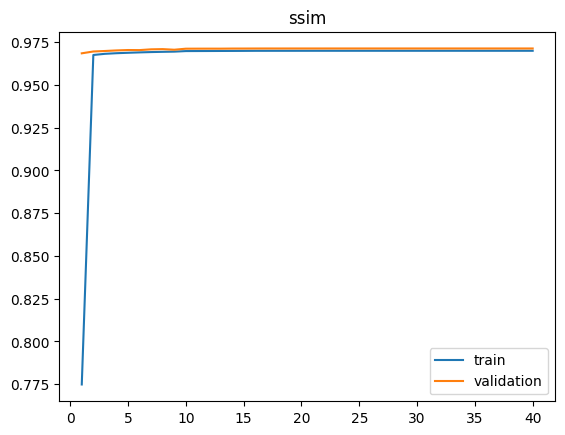

In [90]:
trainSRModel(name='rdn', weights='experiment/rdn_mae/bestWeigths.tf', loss='mae', augment=False, batch_size=32, train_sample=None, val_sample=None, epochs=50)

Epoch 1/50
1288/1288 [==============================] - 1527s 597ms/step - loss: 0.0116 - mae: 0.0116 - mse: 5.9125e-04 - SSIM: 0.9345 - PSNR: 34.3311 - val_loss: 0.0075 - val_mae: 0.0075 - val_mse: 2.0639e-04 - val_SSIM: 0.9683 - val_PSNR: 37.4978 - lr: 0.0010 - wd: 0.0040
Epoch 2/50
1288/1288 [==============================] - 579s 449ms/step - loss: 0.0101 - mae: 0.0101 - mse: 3.8677e-04 - SSIM: 0.9488 - PSNR: 35.1150 - val_loss: 0.0077 - val_mae: 0.0077 - val_mse: 2.0984e-04 - val_SSIM: 0.9690 - val_PSNR: 37.4130 - lr: 0.0010 - wd: 0.0040
Epoch 3/50
1288/1288 [==============================] - 597s 463ms/step - loss: 0.0097 - mae: 0.0097 - mse: 3.6726e-04 - SSIM: 0.9506 - PSNR: 35.3965 - val_loss: 0.0073 - val_mae: 0.0073 - val_mse: 1.9705e-04 - val_SSIM: 0.9695 - val_PSNR: 37.7005 - lr: 0.0010 - wd: 0.0040
Epoch 4/50
1288/1288 [==============================] - 588s 456ms/step - loss: 0.0096 - mae: 0.0096 - mse: 3.6113e-04 - SSIM: 0.9517 - PSNR: 35.4860 - val_loss: 0.0078 - val_ma

1288/1288 [==============================] - 563s 437ms/step - loss: 0.0090 - mae: 0.0090 - mse: 3.3657e-04 - SSIM: 0.9548 - PSNR: 35.8532 - val_loss: 0.0070 - val_mae: 0.0070 - val_mse: 1.8471e-04 - val_SSIM: 0.9712 - val_PSNR: 37.9767 - lr: 1.0000e-07 - wd: 4.0000e-07
Epoch 31/50
1288/1288 [==============================] - 563s 437ms/step - loss: 0.0092 - mae: 0.0092 - mse: 3.4562e-04 - SSIM: 0.9526 - PSNR: 35.7245 - val_loss: 0.0070 - val_mae: 0.0070 - val_mse: 1.8470e-04 - val_SSIM: 0.9712 - val_PSNR: 37.9768 - lr: 1.0000e-07 - wd: 4.0000e-07
Epoch 32/50
1288/1288 [==============================] - 563s 437ms/step - loss: 0.0092 - mae: 0.0092 - mse: 3.3993e-04 - SSIM: 0.9523 - PSNR: 35.7531 - val_loss: 0.0070 - val_mae: 0.0070 - val_mse: 1.8471e-04 - val_SSIM: 0.9712 - val_PSNR: 37.9767 - lr: 1.0000e-08 - wd: 4.0000e-08
Epoch 33/50
1288/1288 [==============================] - 564s 438ms/step - loss: 0.0090 - mae: 0.0090 - mse: 3.3075e-04 - SSIM: 0.9546 - PSNR: 35.8771 - val_loss: 

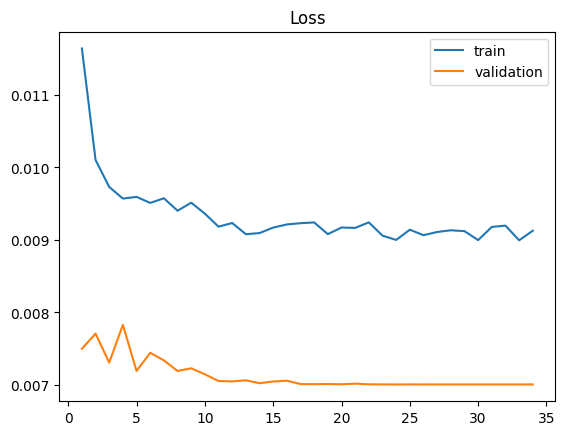

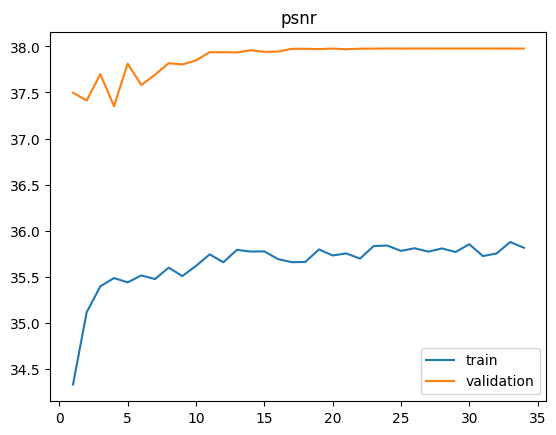

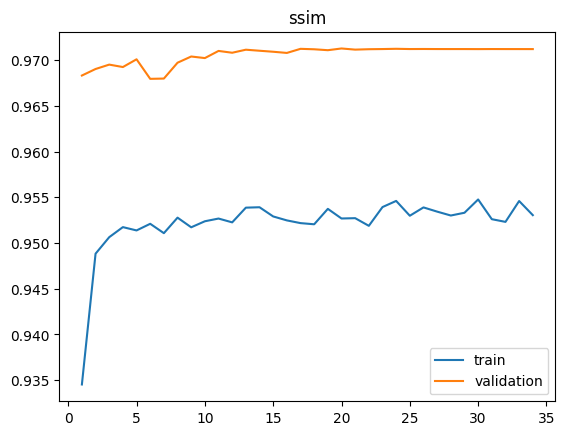

In [91]:
trainSRModel(name='rdn', weights='experiment/rdn_mae_aug/bestWeigths.tf', loss='mae', augment=True, batch_size=32, train_sample=None, val_sample=None, epochs=50)

# Alternative loss functions for ResUNet architecture

Epoch 1/50
1288/1288 [==============================] - 1429s 372ms/step - loss: 4.9640e-04 - mae: 0.0090 - mse: 4.9640e-04 - SSIM: 0.9785 - PSNR: 39.0608 - val_loss: 6.8947e-05 - val_mae: 0.0059 - val_mse: 6.8947e-05 - val_SSIM: 0.9916 - val_PSNR: 41.8543 - lr: 0.0010 - wd: 0.0040
Epoch 2/50
1288/1288 [==============================] - 272s 211ms/step - loss: 5.9185e-05 - mae: 0.0049 - mse: 5.9185e-05 - SSIM: 0.9932 - PSNR: 43.6098 - val_loss: 1.4841e-05 - val_mae: 0.0024 - val_mse: 1.4841e-05 - val_SSIM: 0.9927 - val_PSNR: 48.4169 - lr: 0.0010 - wd: 0.0040
Epoch 3/50
1288/1288 [==============================] - 272s 211ms/step - loss: 4.0562e-05 - mae: 0.0041 - mse: 4.0562e-05 - SSIM: 0.9955 - PSNR: 45.3799 - val_loss: 3.0457e-05 - val_mae: 0.0039 - val_mse: 3.0457e-05 - val_SSIM: 0.9877 - val_PSNR: 45.2684 - lr: 0.0010 - wd: 0.0040
Epoch 4/50
1288/1288 [==============================] - 272s 211ms/step - loss: 3.6147e-05 - mae: 0.0038 - mse: 3.6147e-05 - SSIM: 0.9959 - PSNR: 46.1723

1288/1288 [==============================] - 271s 210ms/step - loss: 5.6953e-06 - mae: 0.0016 - mse: 5.6953e-06 - SSIM: 0.9991 - PSNR: 53.9520 - val_loss: 1.6206e-06 - val_mae: 8.0642e-04 - val_mse: 1.6206e-06 - val_SSIM: 0.9993 - val_PSNR: 58.1293 - lr: 1.0000e-08 - wd: 4.0000e-08
Epoch 30/50
1288/1288 [==============================] - 271s 210ms/step - loss: 5.6196e-06 - mae: 0.0016 - mse: 5.6196e-06 - SSIM: 0.9991 - PSNR: 53.9327 - val_loss: 1.6036e-06 - val_mae: 8.0109e-04 - val_mse: 1.6036e-06 - val_SSIM: 0.9993 - val_PSNR: 58.1742 - lr: 1.0000e-08 - wd: 4.0000e-08
Epoch 31/50
1288/1288 [==============================] - 271s 210ms/step - loss: 5.8086e-06 - mae: 0.0016 - mse: 5.8086e-06 - SSIM: 0.9991 - PSNR: 53.7705 - val_loss: 1.6142e-06 - val_mae: 8.0424e-04 - val_mse: 1.6142e-06 - val_SSIM: 0.9993 - val_PSNR: 58.1430 - lr: 1.0000e-08 - wd: 4.0000e-08
Epoch 32/50
1288/1288 [==============================] - 271s 211ms/step - loss: 5.4484e-06 - mae: 0.0015 - mse: 5.4484e-06 - S

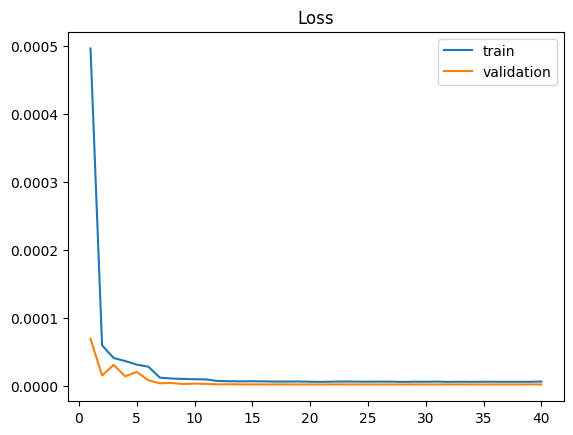

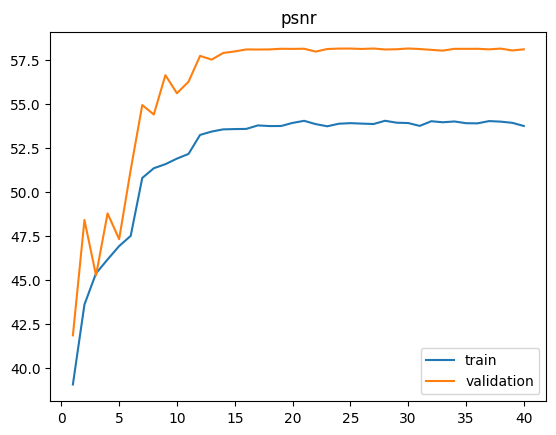

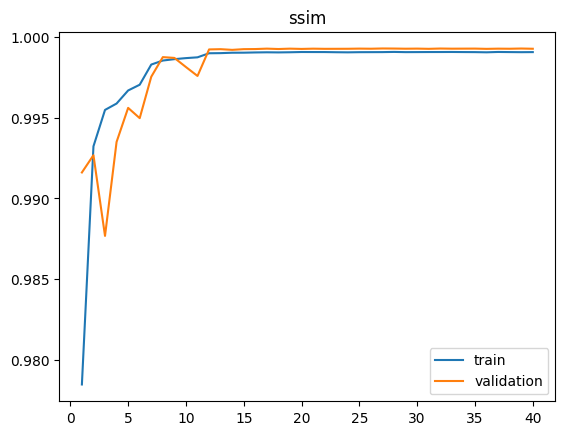

In [92]:
trainModel(name='resunet', loss='mse', augment=False, batch_size=32, train_sample=None, val_sample=None, epochs=50)

Epoch 1/50
1288/1288 [==============================] - 1429s 371ms/step - loss: 0.0013 - mae: 0.0139 - mse: 0.0013 - SSIM: 0.9384 - PSNR: 33.3756 - val_loss: 6.3274e-05 - val_mae: 0.0046 - val_mse: 6.3274e-05 - val_SSIM: 0.9884 - val_PSNR: 42.2747 - lr: 0.0010 - wd: 0.0040
Epoch 2/50
1288/1288 [==============================] - 272s 211ms/step - loss: 3.7796e-04 - mae: 0.0097 - mse: 3.7796e-04 - SSIM: 0.9624 - PSNR: 35.8823 - val_loss: 6.2750e-05 - val_mae: 0.0046 - val_mse: 6.2750e-05 - val_SSIM: 0.9903 - val_PSNR: 42.4739 - lr: 0.0010 - wd: 0.0040
Epoch 3/50
1288/1288 [==============================] - 274s 213ms/step - loss: 2.7866e-04 - mae: 0.0082 - mse: 2.7866e-04 - SSIM: 0.9691 - PSNR: 37.3881 - val_loss: 4.6778e-05 - val_mae: 0.0036 - val_mse: 4.6778e-05 - val_SSIM: 0.9913 - val_PSNR: 43.7277 - lr: 0.0010 - wd: 0.0040
Epoch 4/50
1288/1288 [==============================] - 275s 213ms/step - loss: 2.6076e-04 - mae: 0.0079 - mse: 2.6076e-04 - SSIM: 0.9712 - PSNR: 37.8257 - val_l

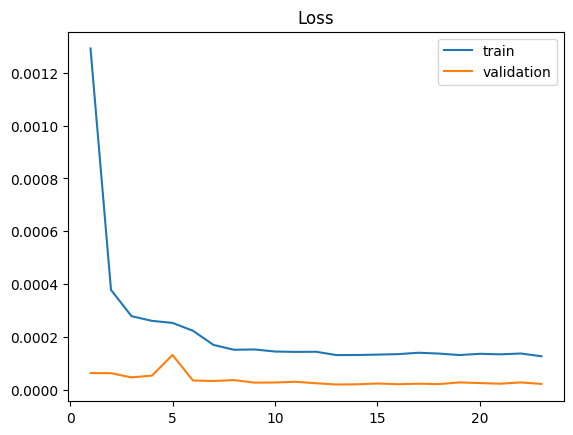

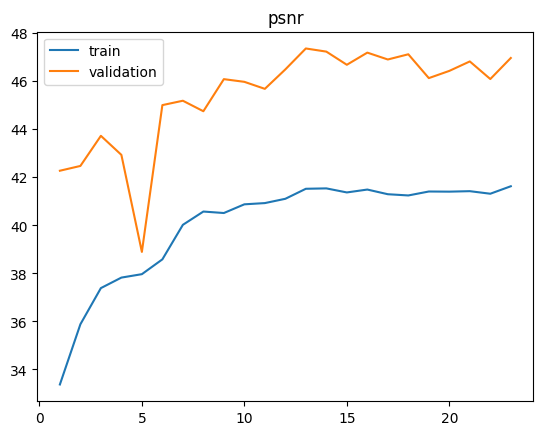

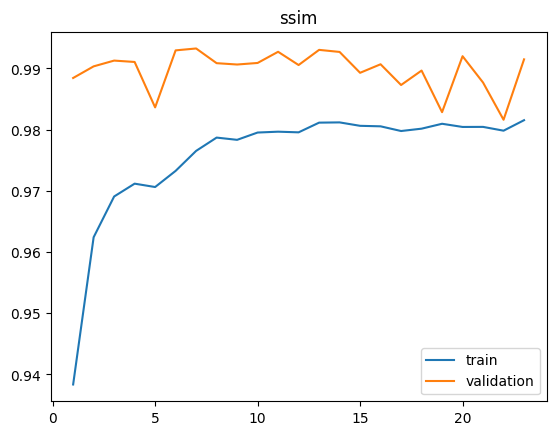

In [93]:
trainModel(name='resunet', loss='mse', augment=True, batch_size=32, train_sample=None, val_sample=None, epochs=50)

Epoch 1/50
1288/1288 [==============================] - 1445s 376ms/step - loss: 0.0107 - mae: 0.0106 - mse: 0.0021 - SSIM: 0.9893 - PSNR: 39.5194 - val_loss: 0.0121 - val_mae: 0.0068 - val_mse: 1.0786e-04 - val_SSIM: 0.9879 - val_PSNR: 40.2726 - lr: 0.0010 - wd: 0.0040
Epoch 2/50
1288/1288 [==============================] - 274s 213ms/step - loss: 0.0017 - mae: 0.0047 - mse: 5.7151e-05 - SSIM: 0.9983 - PSNR: 44.3211 - val_loss: 0.0015 - val_mae: 0.0033 - val_mse: 2.1530e-05 - val_SSIM: 0.9985 - val_PSNR: 46.7671 - lr: 0.0010 - wd: 0.0040
Epoch 3/50
1288/1288 [==============================] - 283s 219ms/step - loss: 0.0011 - mae: 0.0038 - mse: 3.7428e-05 - SSIM: 0.9989 - PSNR: 46.5087 - val_loss: 0.0226 - val_mae: 0.0053 - val_mse: 8.9049e-05 - val_SSIM: 0.9774 - val_PSNR: 40.7087 - lr: 0.0010 - wd: 0.0040
Epoch 4/50
1288/1288 [==============================] - 297s 230ms/step - loss: 8.0966e-04 - mae: 0.0034 - mse: 3.2031e-05 - SSIM: 0.9992 - PSNR: 47.0996 - val_loss: 0.0391 - val_ma

1288/1288 [==============================] - 278s 216ms/step - loss: 9.0342e-05 - mae: 0.0010 - mse: 2.8107e-06 - SSIM: 0.9999 - PSNR: 57.6489 - val_loss: 5.3812e-05 - val_mae: 3.6021e-04 - val_mse: 5.2970e-07 - val_SSIM: 0.9999 - val_PSNR: 63.4873 - lr: 1.0000e-07 - wd: 4.0000e-07
Epoch 30/50
1288/1288 [==============================] - 280s 217ms/step - loss: 9.0306e-05 - mae: 0.0010 - mse: 2.7966e-06 - SSIM: 0.9999 - PSNR: 57.5678 - val_loss: 5.1905e-05 - val_mae: 3.5493e-04 - val_mse: 5.2458e-07 - val_SSIM: 0.9999 - val_PSNR: 63.5381 - lr: 1.0000e-08 - wd: 4.0000e-08


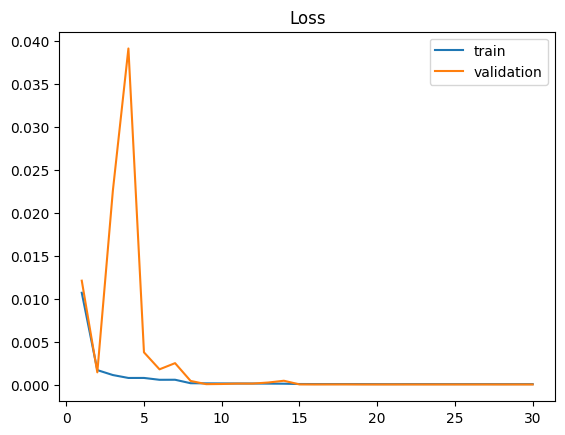

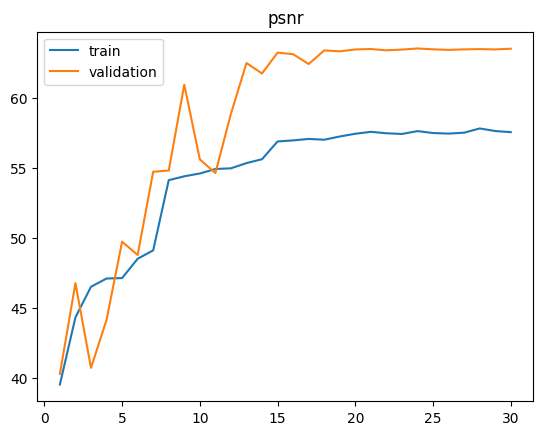

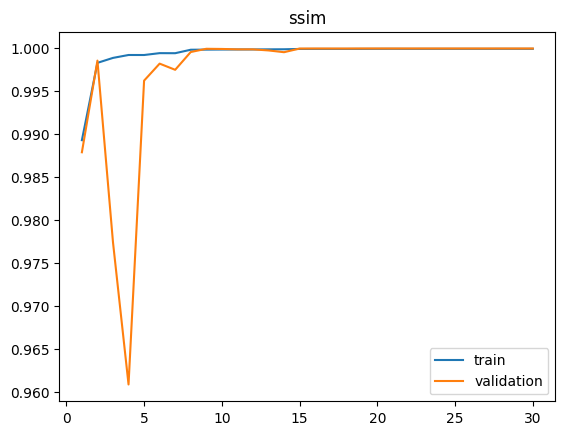

In [94]:
trainModel(name='resunet', loss='ssim', augment=False, batch_size=32, train_sample=None, val_sample=None, epochs=50)

Epoch 1/50
1288/1288 [==============================] - 1443s 369ms/step - loss: 0.0393 - mae: 0.0151 - mse: 0.0021 - SSIM: 0.9607 - PSNR: 33.2609 - val_loss: 0.0056 - val_mae: 0.0054 - val_mse: 9.5354e-05 - val_SSIM: 0.9944 - val_PSNR: 40.4056 - lr: 0.0010 - wd: 0.0040
Epoch 2/50
1288/1288 [==============================] - 269s 208ms/step - loss: 0.0251 - mae: 0.0100 - mse: 4.0147e-04 - SSIM: 0.9749 - PSNR: 35.7539 - val_loss: 0.0069 - val_mae: 0.0088 - val_mse: 1.7358e-04 - val_SSIM: 0.9931 - val_PSNR: 37.7272 - lr: 0.0010 - wd: 0.0040
Epoch 3/50
1288/1288 [==============================] - 269s 208ms/step - loss: 0.0203 - mae: 0.0086 - mse: 2.9272e-04 - SSIM: 0.9797 - PSNR: 37.1629 - val_loss: 0.0214 - val_mae: 0.0067 - val_mse: 8.4965e-05 - val_SSIM: 0.9786 - val_PSNR: 40.9767 - lr: 0.0010 - wd: 0.0040
Epoch 4/50
1288/1288 [==============================] - 269s 209ms/step - loss: 0.0182 - mae: 0.0082 - mse: 2.6727e-04 - SSIM: 0.9818 - PSNR: 37.7886 - val_loss: 0.0076 - val_mae: 0

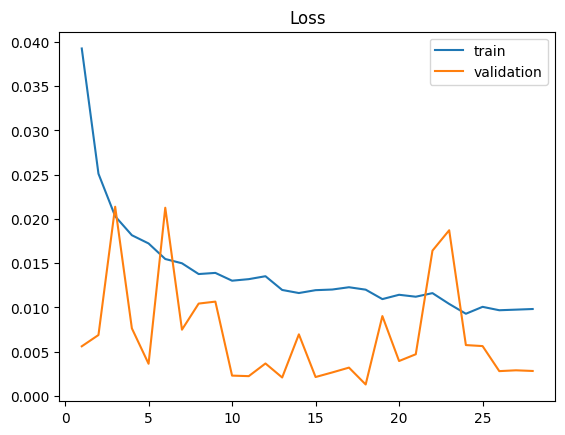

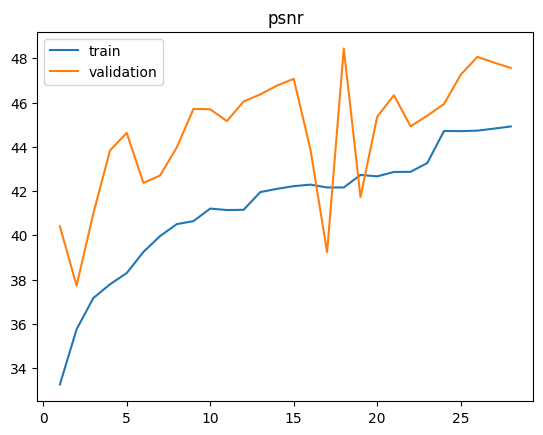

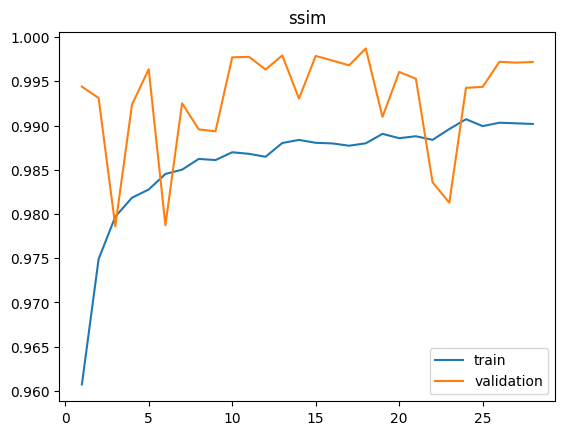

In [95]:
trainModel(name='resunet', loss='ssim', augment=True, batch_size=32, train_sample=None, val_sample=None, epochs=50)